# Signal Processing - Homework 1

---

**Student:** Oleksandra Ostafiichuk  
**University:** Ukrainian Catholic University  
**Year:** 3rd Year  
**Program:** IT and Decision Analytics  
**Date:** September 2025

---


## OBJECTIVE

To learn fundamental methods of recording, processing, and visualizing signals of various types (gyroscope, accelerometer, audio, EEG). To understand working with different sampling rates, analyze the impact of sampling rate on signal quality.


In [49]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
from glob import glob
import seaborn as sns
import sounddevice as sd
import scipy.io.wavfile as wavfile
from IPython.display import Audio, display
import time


## Task 0

Створити функцію, яка розраховує тривалість дискретних сигналів. З її допомогою визначити тривалості всіх сигналів, що використовуються в роботі.

In [50]:
def calculate_signal_duration(signal, sampling_rate=256):
    if signal.ndim > 1:
        signal = signal.flatten()
    
    n_samples = len(signal)
    duration = n_samples / sampling_rate
    time = np.linspace(0, duration, n_samples)
    
    print(f"Signal length: {n_samples} samples")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Sampling rate: {sampling_rate} Hz")
    
    return duration, time

Usage examples are in the next tasks

## Task 4

1. Побудувати функцію для виводу на графік ділянки сигналів. В функцію передавати: час початку та закінчення ділянки (в секундах), вектор з відліками сигналу, частоту дискретизації. 
2. Передбачити перевірку правильності введення моментів часу, та можливість отримання за допомогою функції вектору з відліками ділянки сигналу та відліками часу. 
3. Використати функцію для виводу ділянки сигналу з виконаних завдань.



In [28]:
def plot_signal_segment (signal, sampling_rate, start_time, end_time, title="Signal segment", return_data = True):
    if signal is None or len(signal) == 0: 
        print ('signal is empty')
        return None
    
    total_duration = len(signal) / sampling_rate

    if start_time < 0:
        print(f"Time can not be negative number {start_time})")
        return None
    
    if end_time > total_duration:
        print(f"End time ({end_time}s) is larger than total duration ({total_duration:.2f}s)")
        return None
    
    if start_time >= end_time:
        print(f"Start time ({start_time}s) should be less than end time")
        return None
    
    start_index = max(math.ceil(start_time * sampling_rate), 0)
    end_index = min(math.floor(end_time * sampling_rate), len(signal))

    segment_signal = signal[start_index:end_index]

    segment_time = np.linspace(start_time, end_time, len(segment_signal))

    plt.figure(figsize=(14, 6))
    plt.plot(segment_time, segment_signal, 'b-', linewidth=0.8)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude (µV)', fontsize=12)
    plt.title(f'{title}\n[{start_time:.2f}s - {end_time:.2f}s]', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    info_text = f'Duration: {end_time-start_time:.2f}s\n'
    info_text += f'Number of counts: {len(segment_signal)}\n'
    info_text += f'Min: {np.min(segment_signal):.2f} µV\n'
    info_text += f'Max: {np.max(segment_signal):.2f} µV\n'
    info_text += f'Average: {np.mean(segment_signal):.2f} µV'
    
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    if return_data:
        print(f"Segment: {len(segment_signal)} counts from {start_time:.2f}s to {end_time:.2f}s")
        return segment_time, segment_signal
    
    return None


Usage examples are in the next tasks

## Task 1

Записати за допомогою смартфону сигнал з внутрішніх датчиків (акселерометр, гіроскоп та ін.) Для цього на смартфон попередньо встановити додаток для реєстрації даних через вбудовані сенсори смартфона (наприклад, https://play.google.com/store/apps/details?id=com.chrystianvieyra.physicstoolboxsuite&pli=1 )

- Запустити додаток та опанувати його. Встановити в налаштуваннях максимальну частоту дискретизації.

- Виконати реєстрацію сигналів з доступних датчиків смартфону при виконанні таких вправ:

    - записати сигнали стоячи, тримати пристрій в руці, яка опущена вздовж тулуба протягом 1 хвилини;
    - почати запис, покласти пристрій в кишеню, постояти 10 секунд, пройти по коридору спокійним кроком, постояти 10 секунд, припинити запис;
    - почати запис, покласти пристрій в кишеню, постояти 10 секунд, пробігти по коридору, постояти 10 секунд, припинити запис. 

- Побудувати графіки сигналів акселерометра і гіроскопа, підписати вісі.
- Зберегти дані в csv-файл для використання в наступних роботах.

- **Gyroscope**: Measures angular velocity in radians per second (rad/s)
- **Accelerometer**: Measures acceleration in meters per second squared (m/s²)


For gyroscope:

In [29]:
def plotting_gyroscope_signal(path):
    df = pd.read_csv(path, skiprows=3, delimiter=';', decimal=',', dtype=str)
    
    df['time'] = df['time'].str.replace(',', '.').astype(float)
    
    df.columns = ['time', 'omega_x', 'omega_y', 'omega_z', 'omega_total']
    
    for col in ['omega_x', 'omega_y', 'omega_z', 'omega_total']:
        df[col] = df[col].str.replace(',', '.').astype(float)
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.plot(df['time'], df['omega_x'], label='ωₓ', color='red', alpha=0.7)
    ax1.plot(df['time'], df['omega_y'], label='ωᵧ', color='green', alpha=0.7)
    ax1.plot(df['time'], df['omega_z'], label='ωᶻ', color='blue', alpha=0.7)
    ax1.set_ylabel('Angular Velocity (rad/s)')
    ax1.set_title('Gyroscope Signal - Individual Components')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return df


For accelerometer

In [30]:
def plotting_acceleration_signal(path):
    df = pd.read_csv(path, skiprows=3, delimiter=';', dtype=str)
    df.iloc[:, 0] = df.iloc[:, 0].str.replace(',', '.').astype(float)
    
    for i in range(1, 5):
        df.iloc[:, i] = df.iloc[:, i].str.replace(',', '.').astype(float)
    
    df.columns = ['time', 'ax', 'ay', 'az', 'aT']
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    ax1.plot(df['time'], df['ax'], label='ax', color='red', alpha=0.7)
    ax1.plot(df['time'], df['ay'], label='ay', color='green', alpha=0.7)
    ax1.plot(df['time'], df['az'], label='az', color='blue', alpha=0.7)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.set_title('Accelerometer Signal - Individual Components')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return df

### No movement signals

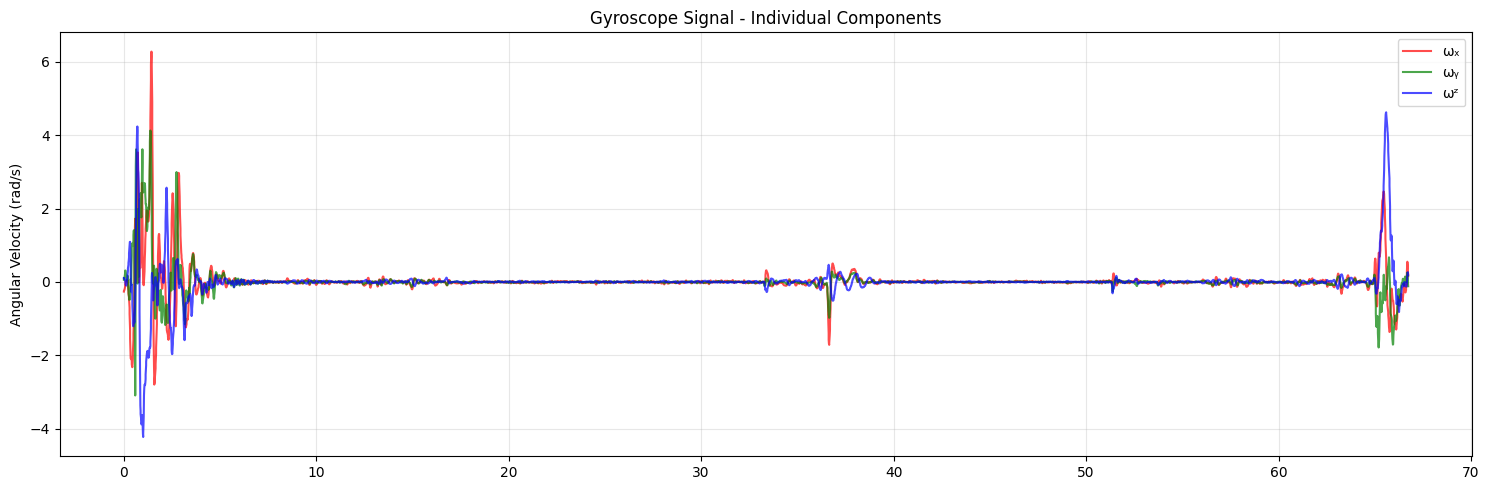

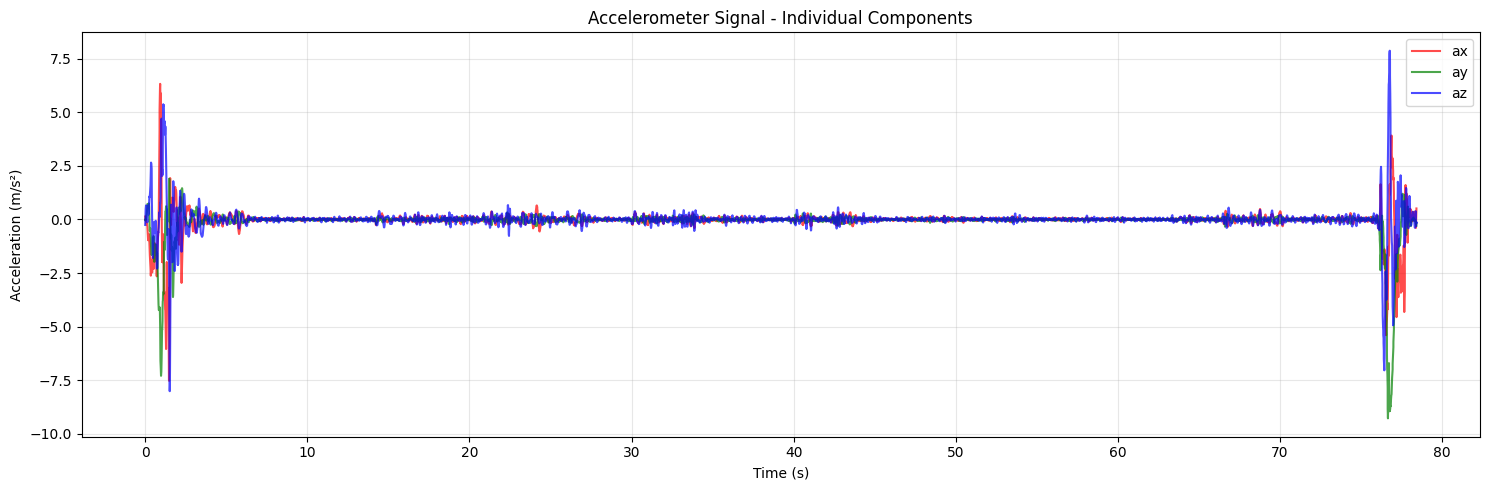

In [31]:
df_gyro = plotting_gyroscope_signal('task_1_signals/gyroscope_no_movement.csv')
df_accel = plotting_acceleration_signal('task_1_signals/linear_acceleration_no_movement.csv')

### Stand Go Stand 

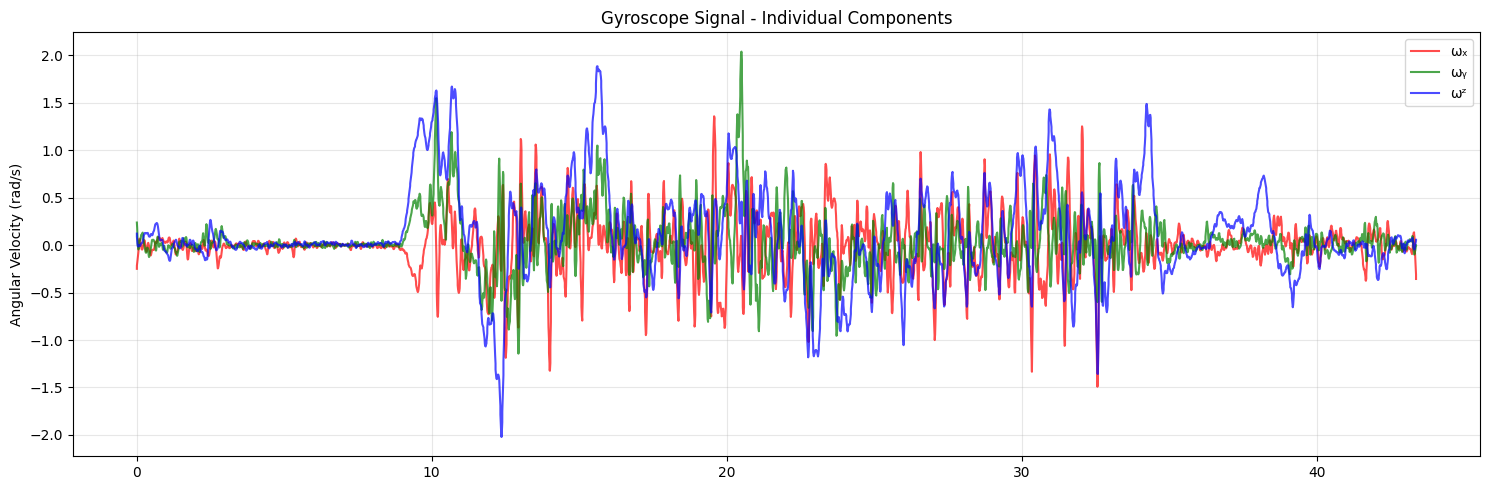

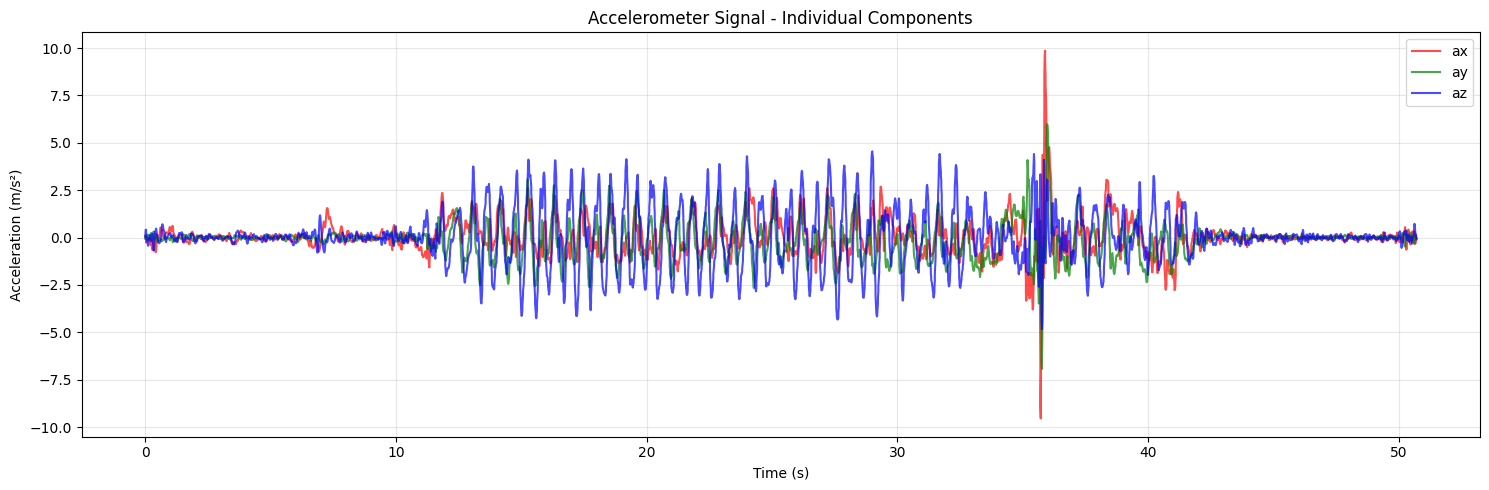

In [32]:
df_gyro = plotting_gyroscope_signal('task_1_signals/gyroscope_standing_walking.csv')
df_accel =plotting_acceleration_signal('task_1_signals/linear_acceleration_standing_walking.csv')

## Task 2

Записати звук з зовнішнього пристрою тривалістю 5 с з допомогою Python. Записати однакові фрази або музику з частотою дискретизації 8 кГц та 44.1 кГц. Прочитати з файлу та прослухати отримані записи. Вивести графік, позначити вісі.

In [33]:
from scipy.signal import butter, filtfilt

def record_and_process(duration=5):
    high_sr = 44100
    
    print(f"Recording for {duration} seconds at {high_sr} Hz...")
    print("Speak now!")
    
    audio_high = sd.rec(int(duration * high_sr), 
                        samplerate=high_sr, 
                        channels=1,
                        dtype='float32')
    sd.wait()
    print("Recording finished!")
    
    audio_int_44k = np.int16(audio_high * 32767)
    wavfile.write("audio_44khz.wav", high_sr, audio_int_44k)
    
    low_sr = 8000
    nyquist = low_sr / 2
    b, a = butter(8, nyquist / (high_sr / 2), btype='low')
    audio_filtered = filtfilt(b, a, audio_high.flatten())
    
    decimation_factor = high_sr // low_sr
    audio_8khz = audio_filtered[::decimation_factor]
    
    audio_int_8k = np.int16(audio_8khz * 32767)
    wavfile.write("audio_8khz.wav", low_sr, audio_int_8k)
    
    print(f"✓ Original saved at 44.1 kHz")
    print(f"✓ Downsampled version saved at 8 kHz")
    
    return audio_high, audio_8khz, high_sr, low_sr

In [34]:
audio_44k, audio_8k, sr_44k, sr_8k = record_and_process(duration=5)


Recording for 5 seconds at 44100 Hz...
Speak now!
Recording finished!
✓ Original saved at 44.1 kHz
✓ Downsampled version saved at 8 kHz


In [35]:

print("=" * 50)
print("play")
print("=" * 50)

print("\n🔊 8 kHz (low quality):")
display(Audio("audio_8khz.wav"))

print("\n🔊 44.1 kHz (good quality):")
display(Audio("audio_44khz.wav"))

play

🔊 8 kHz (low quality):



🔊 44.1 kHz (good quality):


In [36]:
def plot_comparison():
    sr1, data1 = wavfile.read("audio_8khz.wav")
    sr2, data2 = wavfile.read("audio_44khz.wav")
    

    if data1.dtype == np.int16:
        data1 = data1.astype(np.float32) / 32767
    if data2.dtype == np.int16:
        data2 = data2.astype(np.float32) / 32767
    

    time1 = np.arange(len(data1)) / sr1
    time2 = np.arange(len(data2)) / sr2
    

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    # 8 kHz
    axes[0].plot(time1, data1, 'b-', linewidth=0.5)
    axes[0].set_title('8 kHz - Низька частота дискретизації')
    axes[0].set_ylabel('Амплітуда')
    axes[0].grid(True, alpha=0.3)
    
    # 44.1 kHz
    axes[1].plot(time2, data2, 'r-', linewidth=0.5)
    axes[1].set_title('44.1 kHz - Висока частота дискретизації')
    axes[1].set_ylabel('Амплітуда')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

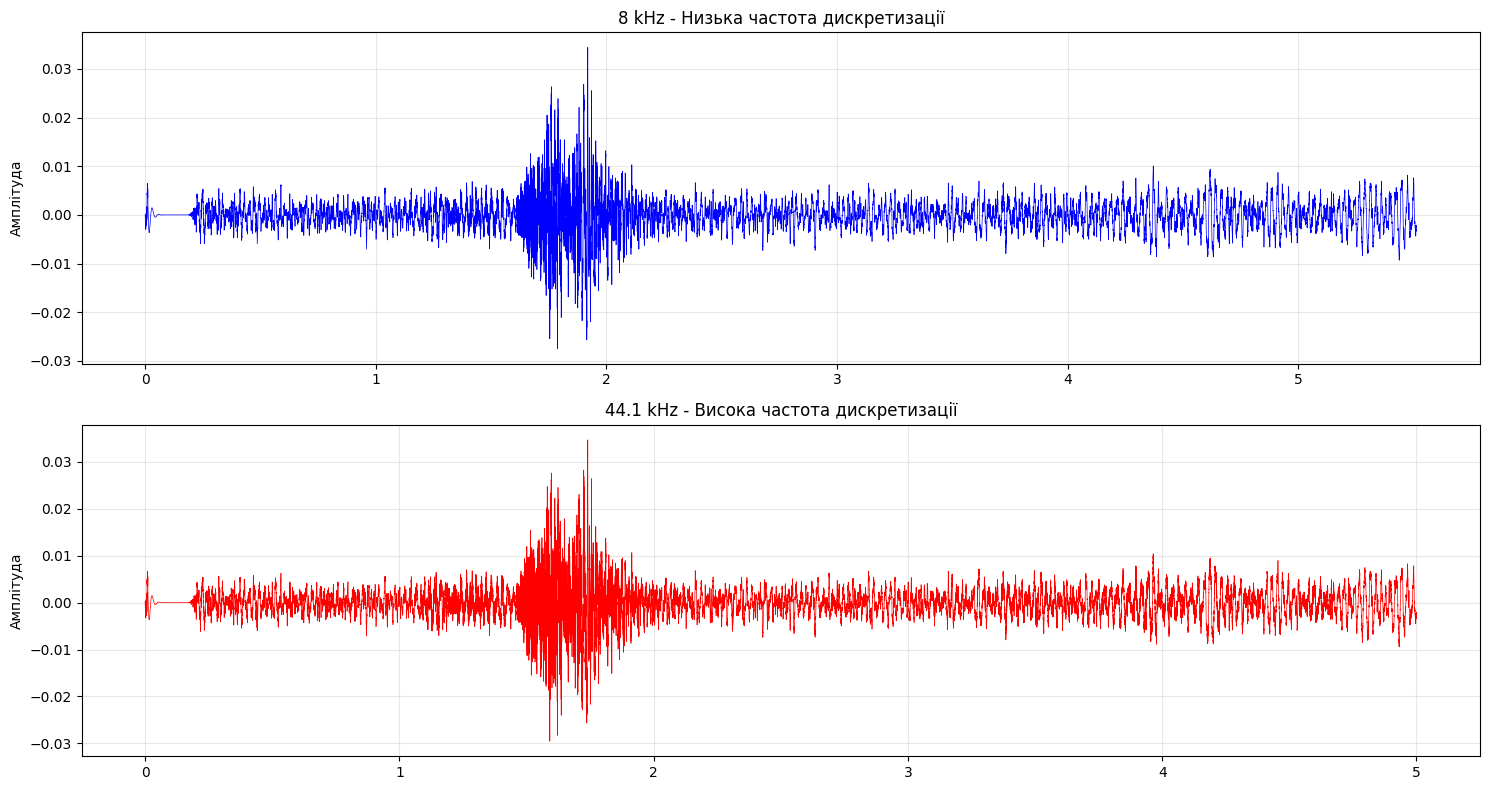

In [37]:
plot_comparison()

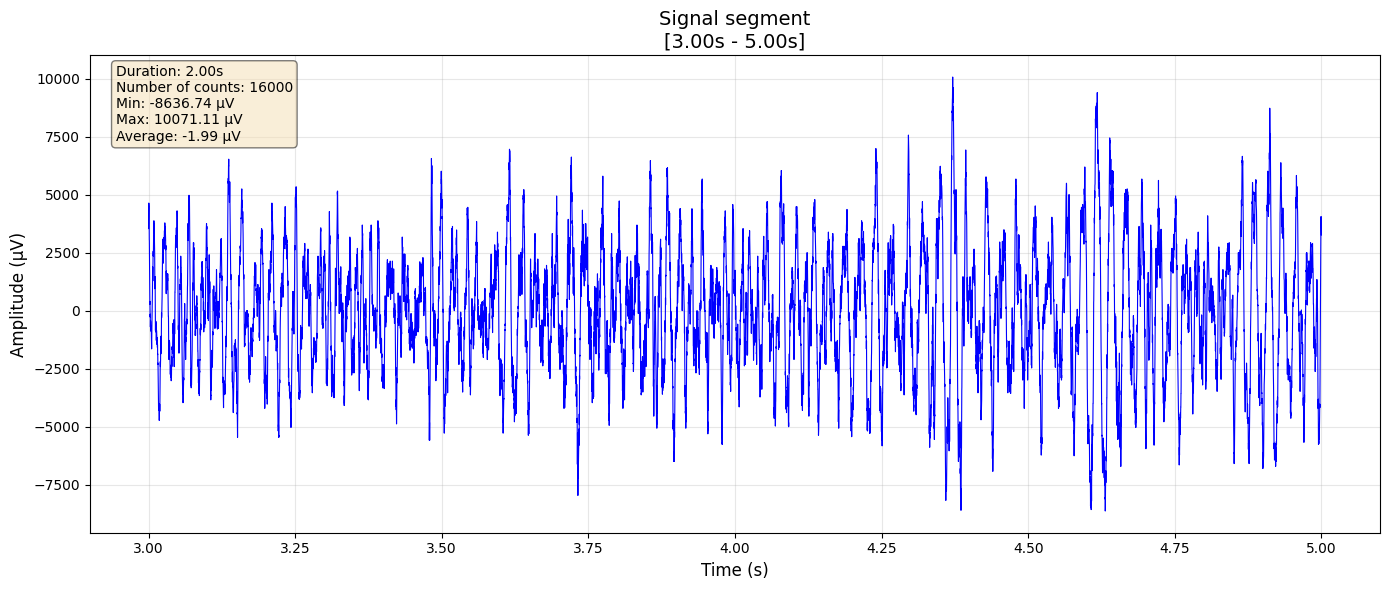

Segment: 16000 counts from 3.00s to 5.00s


(array([3.        , 3.00012501, 3.00025002, ..., 4.99974998, 4.99987499,
        5.        ]),
 array([3540.1472, 3753.7766, 3936.8877, ..., 3784.2952, 3540.1472,
        3265.4805], dtype=float32))

In [38]:
sr1, signal = wavfile.read("audio_8khz.wav")

if signal.dtype == np.int16:
    signal = signal.astype(np.float32) / 32767
signal = signal * 1000000

plot_signal_segment(signal, 8000, 3, 5)

## Task 3

Прочитати сигнали ЕЕГ здорової та хворої людини, отримані з допомогою комп’ютерного електроенцефалографа та збережені у mat-файлі (MatLAB). Вивести графік, позначити вісі. Зберегти отриманий сигнал для використання в наступних роботах.
Файли архіву EEG_healthy.rar та EEG_sick.rar; обрати один сигнал; ЕЕГ дискретизована з частотою 256 Гц, значення напруги подано в мікровольтах.

- **EEG (Electroencephalogram)**: Bioelectrical brain activity measured in microvolts (μV)


Signal length: 2561 samples
Duration: 10.00 seconds
Sampling rate: 256 Hz
Signal length: 2561 samples
Duration: 10.00 seconds
Sampling rate: 256 Hz


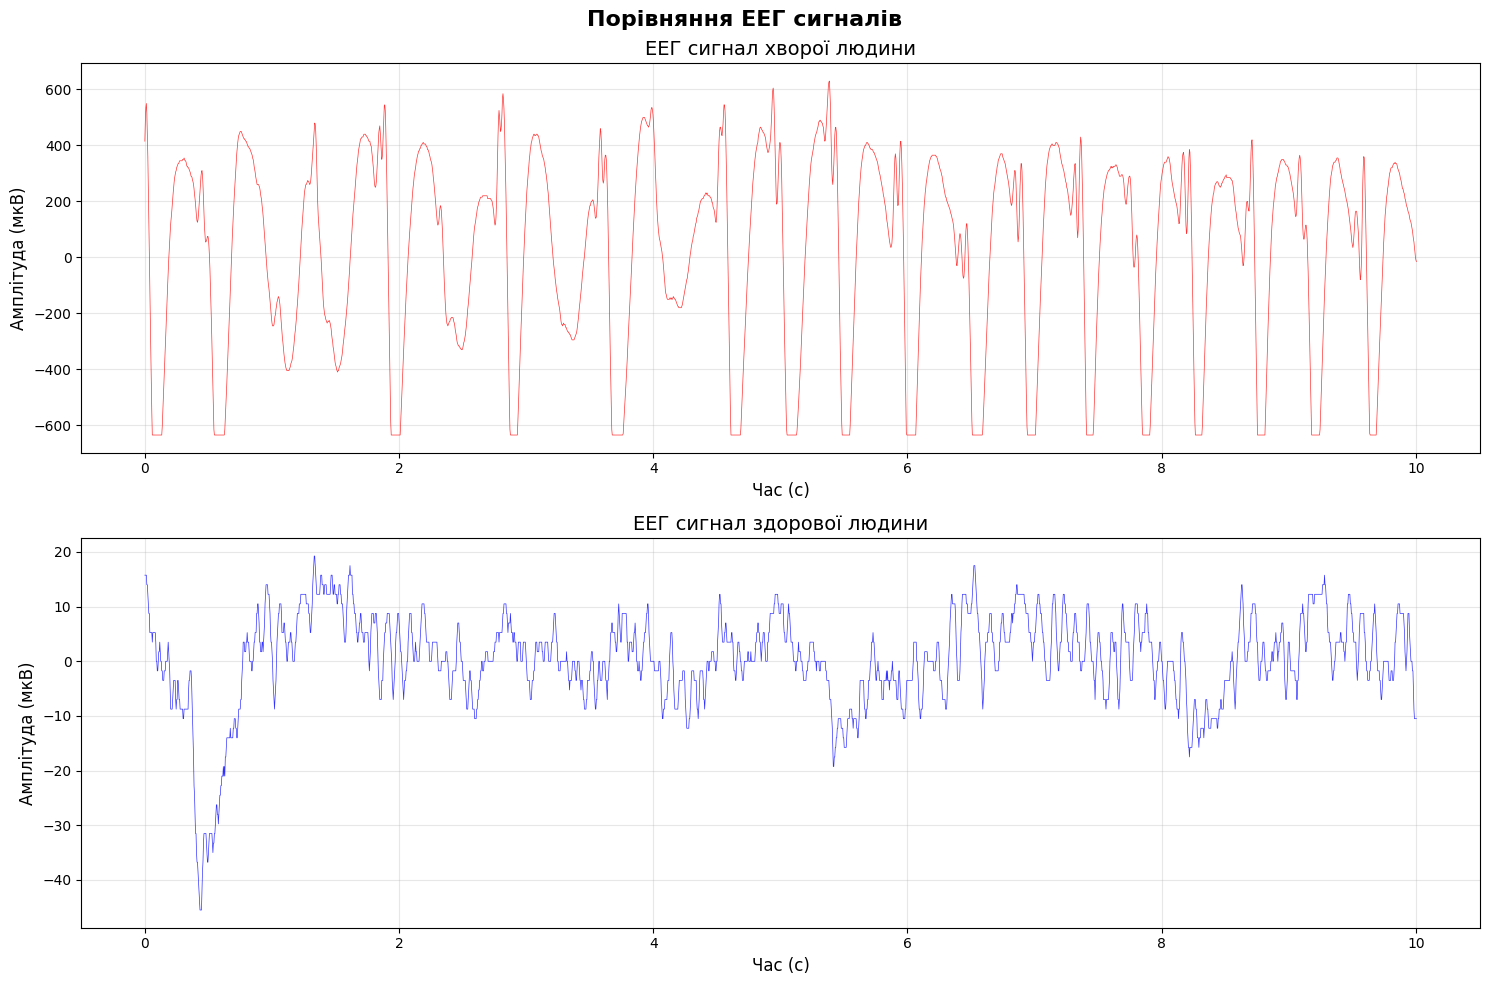

In [39]:
def process_eeg(file_path, header, sampling_rate=256):
    mat_data = sio.loadmat(file_path)
    
    eeg_signal = mat_data["sig"]

    duration, time = calculate_signal_duration(eeg_signal)
    
    if eeg_signal.ndim > 1:
        eeg_signal = eeg_signal.flatten()
    
    return eeg_signal, time, header

if __name__ == "__main__":
    eeg_sick, time_sick, header_sick = process_eeg("EEG/eeg_sick_1.mat", 'ЕЕГ сигнал хворої людини')
    eeg_healthy, time_healthy, header_healthy = process_eeg("EEG/eeg_healthy_1.mat", 'ЕЕГ сигнал здорової людини')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle('Порівняння ЕЕГ сигналів', fontsize=16, fontweight='bold')
    
    ax1.plot(time_sick, eeg_sick, 'r-', linewidth=0.5, alpha=0.8)
    ax1.set_xlabel('Час (с)', fontsize=12)
    ax1.set_ylabel('Амплітуда (мкВ)', fontsize=12)
    ax1.set_title(header_sick, fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(time_healthy, eeg_healthy, 'b-', linewidth=0.5, alpha=0.8)
    ax2.set_xlabel('Час (с)', fontsize=12)
    ax2.set_ylabel('Амплітуда (мкВ)', fontsize=12)
    ax2.set_title(header_healthy, fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    np.save('eeg_sick_signal.npy', eeg_sick)
    data_sick = np.column_stack((time_sick, eeg_sick))
    
    np.save('eeg_healthy_signal.npy', eeg_healthy)
    data_healthy = np.column_stack((time_healthy, eeg_healthy))
    plt.show()

Example of usage a function from task 4:

In [40]:
signal = np.load('eeg_sick_signal.npy')
plot_signal_segment(signal, 256, 10, 7)

Start time (10s) should be less than end time


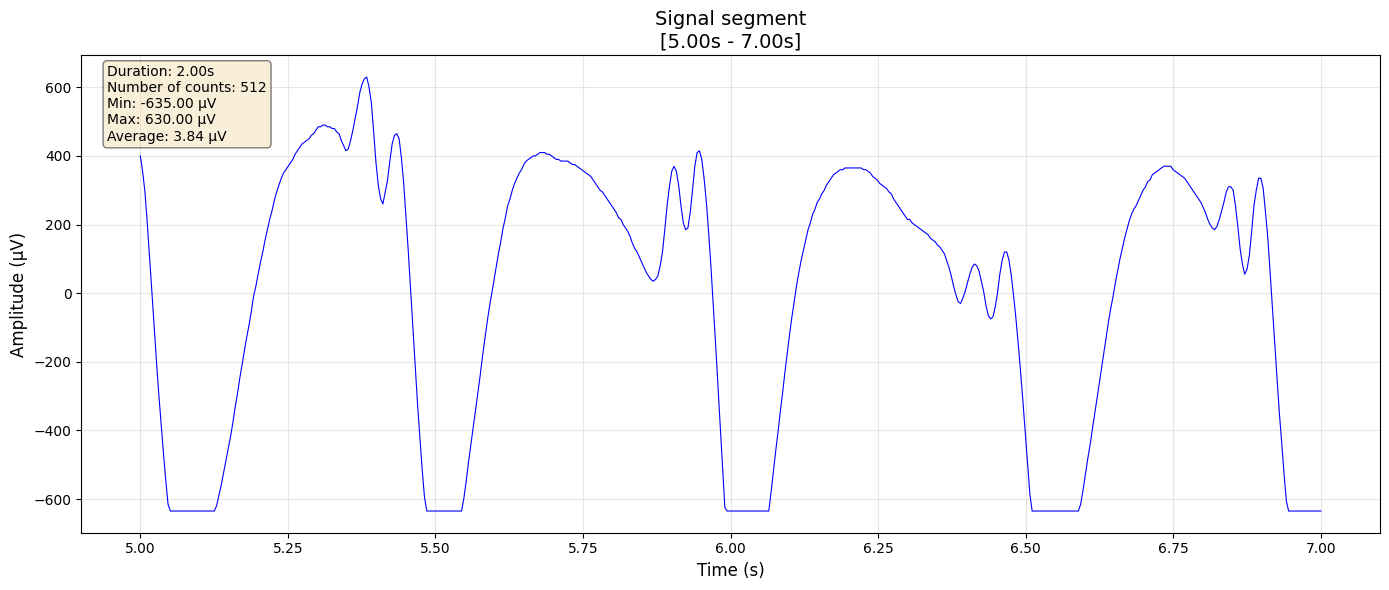

Segment: 512 counts from 5.00s to 7.00s


(array([5.        , 5.00391389, 5.00782779, 5.01174168, 5.01565558,
        5.01956947, 5.02348337, 5.02739726, 5.03131115, 5.03522505,
        5.03913894, 5.04305284, 5.04696673, 5.05088063, 5.05479452,
        5.05870841, 5.06262231, 5.0665362 , 5.0704501 , 5.07436399,
        5.07827789, 5.08219178, 5.08610568, 5.09001957, 5.09393346,
        5.09784736, 5.10176125, 5.10567515, 5.10958904, 5.11350294,
        5.11741683, 5.12133072, 5.12524462, 5.12915851, 5.13307241,
        5.1369863 , 5.1409002 , 5.14481409, 5.14872798, 5.15264188,
        5.15655577, 5.16046967, 5.16438356, 5.16829746, 5.17221135,
        5.17612524, 5.18003914, 5.18395303, 5.18786693, 5.19178082,
        5.19569472, 5.19960861, 5.2035225 , 5.2074364 , 5.21135029,
        5.21526419, 5.21917808, 5.22309198, 5.22700587, 5.23091977,
        5.23483366, 5.23874755, 5.24266145, 5.24657534, 5.25048924,
        5.25440313, 5.25831703, 5.26223092, 5.26614481, 5.27005871,
        5.2739726 , 5.2778865 , 5.28180039, 5.28

In [41]:
signal = np.load('eeg_sick_signal.npy')
plot_signal_segment(signal, 256, 5, 7)

## Task 7 

Прочитати сигнали стабілограми людини, що були зареєстровані за допомогою платформи Wii Balance Board (https://en.wikipedia.org/wiki/Wii_Balance_Board). В папці data присутні сигнали для двох груп спортсменів - гравців в гандбол та акробатів, handball та acrobats відповідно. Кожний тип спортсменів виконував певні експерименти:

- base_close - стояти рівно, ноги разом, очі закриті
- base_open - стояти рівно, ноги разом, очі відкриті
- sway_front-back_30 - покачування вперед-назад під кутом 30 градусів, ноги разом, очі відкриті
- sway_front_back_60 - покачування вперед-назад під кутом 60 градусів, ноги разом, очі відкриті
- sway_left-right_30 - покачування вліво-вправо під кутом 30 градусів, ноги разом, очі відкриті
- sway_left-right_60 - покачування вліво-вправо під кутом 60 градусів, ноги разом, очі відкриті

### Виконати такі завдання:
1) Прочитати сигнали CoP (Center-of-Pressure) стабілограм спортсменів, що спеціалізуються на різних видах спорту. Для цього пропонуємо використати функцію read_csv бібліотеки роботи з табличними даними Pandas. Побудувати графіки (в протокол включити кілька графіків для прикладу). 

    Порядок стовпців в файлі:
    - time_ms - time in ms [column0]
    - top_left_f_kg - raw top_left sensor data [column1]
    - top_right_f_kg = raw top_right sensor data [column2]
    - bottom_left_f_kg = raw bottom_left sensor data [column3]
    - bottom_right_f_kg = raw bottom_right sensor data [column4]
    - cop_x = CoP X axis, mm [column5]
    - cop_y = CoP Y axis, mm [column6]
    - total_f = Total force [column7]

2) Обрати будь-які два типи сигналів (наприклад, base-open та sway_left-right_60) для двох типів спортсменів. 

3) Для кожного сигналу в папці відповідного типу порахувати статистичні параметри (середнє значення, медіанне значення, середнє квадратичне відхилення), окремо по осям Х та Y, звести в таблицю.

Reading stabilogram data:

In [42]:
def read_stabilogram_data(file_path):
    column_names = [
        'time_ms',          
        'top_left_f_kg',    
        'top_right_f_kg',   
        'bottom_left_f_kg', 
        'bottom_right_f_kg',
        'cop_x',            
        'cop_y',            
        'total_f'           
    ]
    try:
        df = pd.read_csv(file_path, sep='\s+', header=None,names=column_names)
        df['time_s'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000.0
        return df
    
    except Exception as e:
        print(f"Exception while reading in {file_path}: {e}")
        return None

Plot for CoP Trajectory:

In [43]:
def plot_cop_trajectory(df, title="CoP trajectory", save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # CoP trajectory in 2d
    ax1 = axes[0, 0]
    ax1.plot(df['cop_x'], df['cop_y'], 'b-', linewidth=0.5, alpha=0.7)
    ax1.scatter(df['cop_x'].iloc[0], df['cop_y'].iloc[0], 
                c='green', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(df['cop_x'].iloc[-1], df['cop_y'].iloc[-1], 
                c='red', s=100, marker='s', label='Finish', zorder=5)
    ax1.set_xlabel('CoP X (mm)', fontsize=11)
    ax1.set_ylabel('CoP Y (mm)', fontsize=11)
    ax1.set_title('Trajectory CoP', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # CoP x
    ax2 = axes[0, 1]
    ax2.plot(df['time_s'], df['cop_x'], 'r-', linewidth=0.8, alpha=0.8)
    ax2.set_xlabel('Time (s)', fontsize=11)
    ax2.set_ylabel('CoP X (mm)', fontsize=11)
    ax2.set_title('CoP oscillation along the X axis', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # stats
    stats_x = f'Average: {df["cop_x"].mean():.2f} mm\n'
    stats_x += f'STD: {df["cop_x"].std():.2f} mm\n'
    stats_x += f'Range: {df["cop_x"].max() - df["cop_x"].min():.2f} mm'
    ax2.text(0.02, 0.98, stats_x, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # CoP Y
    ax3 = axes[1, 0]
    ax3.plot(df['time_s'], df['cop_y'], 'g-', linewidth=0.8, alpha=0.8)
    ax3.set_xlabel('Time (с)', fontsize=11)
    ax3.set_ylabel('CoP Y (mm)', fontsize=11)
    ax3.set_title('CoP oscillation along the Y axis', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # stats
    stats_y = f'Average: {df["cop_y"].mean():.2f} mm\n'
    stats_y += f'STD: {df["cop_y"].std():.2f} mm\n'
    stats_y += f'Range: {df["cop_y"].max() - df["cop_y"].min():.2f} mm'
    ax3.text(0.02, 0.98, stats_y, transform=ax3.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # force
    ax4 = axes[1, 1]
    ax4.plot(df['time_s'], df['total_f'], 'm-', linewidth=0.8, alpha=0.8)
    ax4.set_xlabel('Time (s)', fontsize=11)
    ax4.set_ylabel('Total force (kg)', fontsize=11)
    ax4.set_title('Total force', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # stats
    stats_f = f'average: {df["total_f"].mean():.2f} kg\n'
    stats_f += f'STD: {df["total_f"].std():.2f} kg\n'
    stats_f += f'Min: {df["total_f"].min():.2f} kg\n'
    stats_f += f'Max: {df["total_f"].max():.2f} kg'
    ax4.text(0.02, 0.98, stats_f, transform=ax4.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig


Example of usage on acrobat base close file:

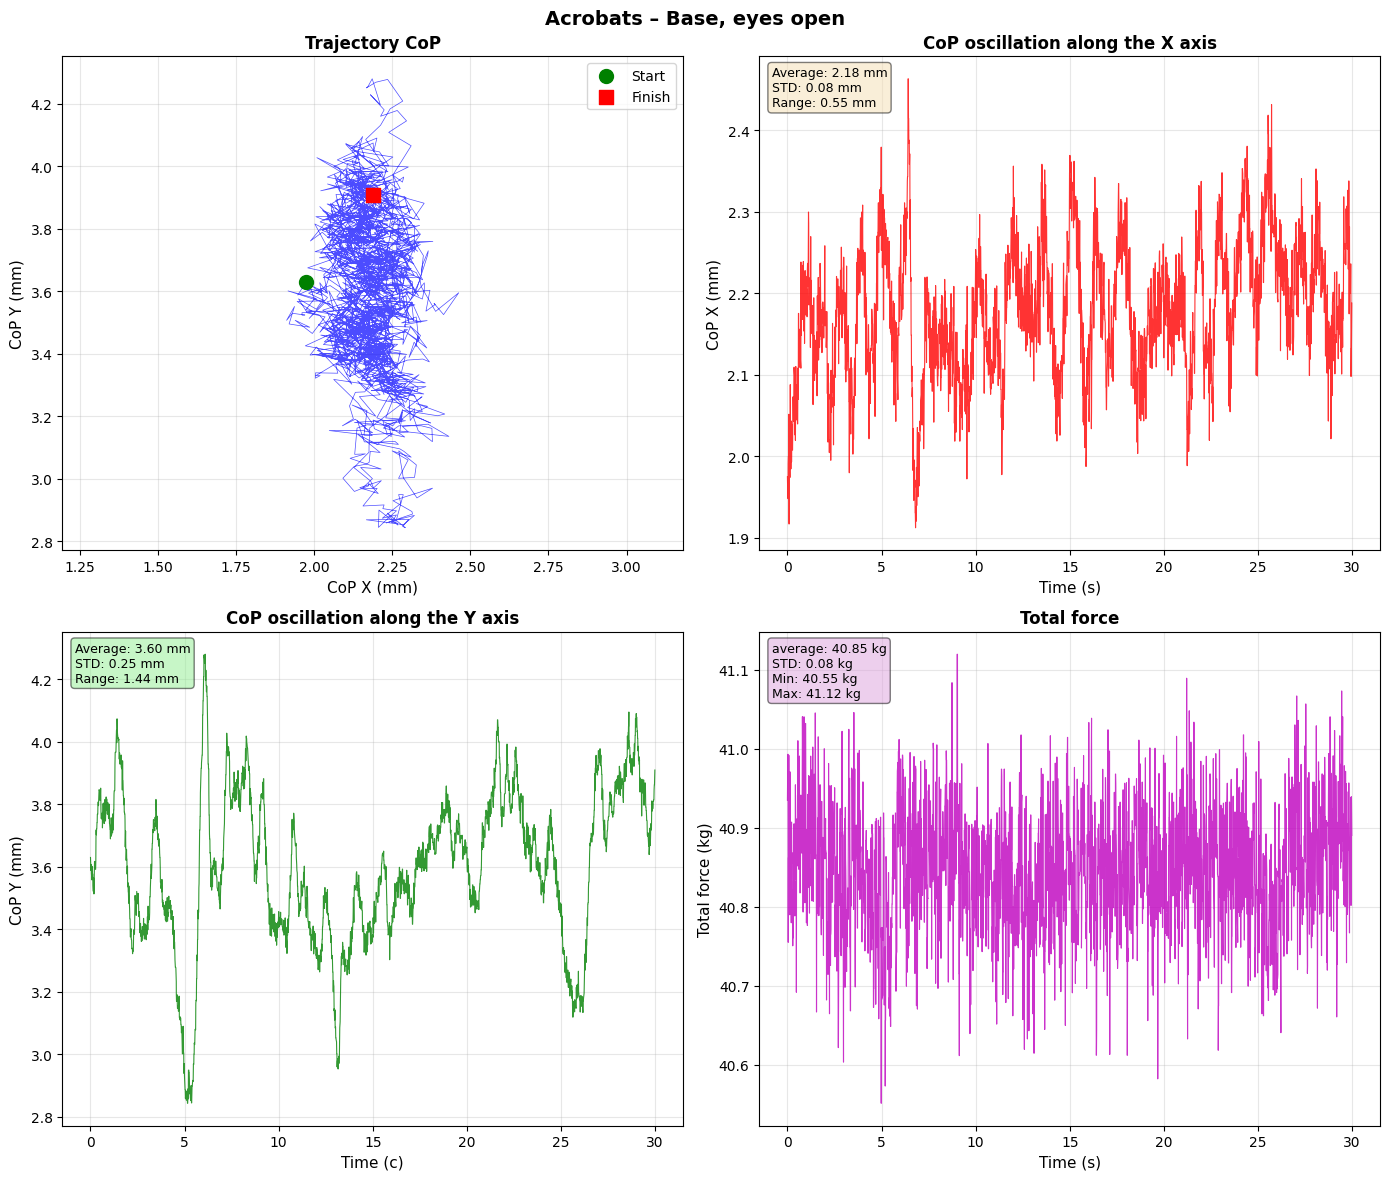

In [44]:
if __name__ == "__main__":
    sample_file = "data/acrobats/base_close/11.csv"
    
    if os.path.exists(sample_file):
        df = read_stabilogram_data(sample_file)
        if df is not None:
            plot_cop_trajectory(df, title="Acrobats – Base, eyes open") 

Applying task 4 in task 7

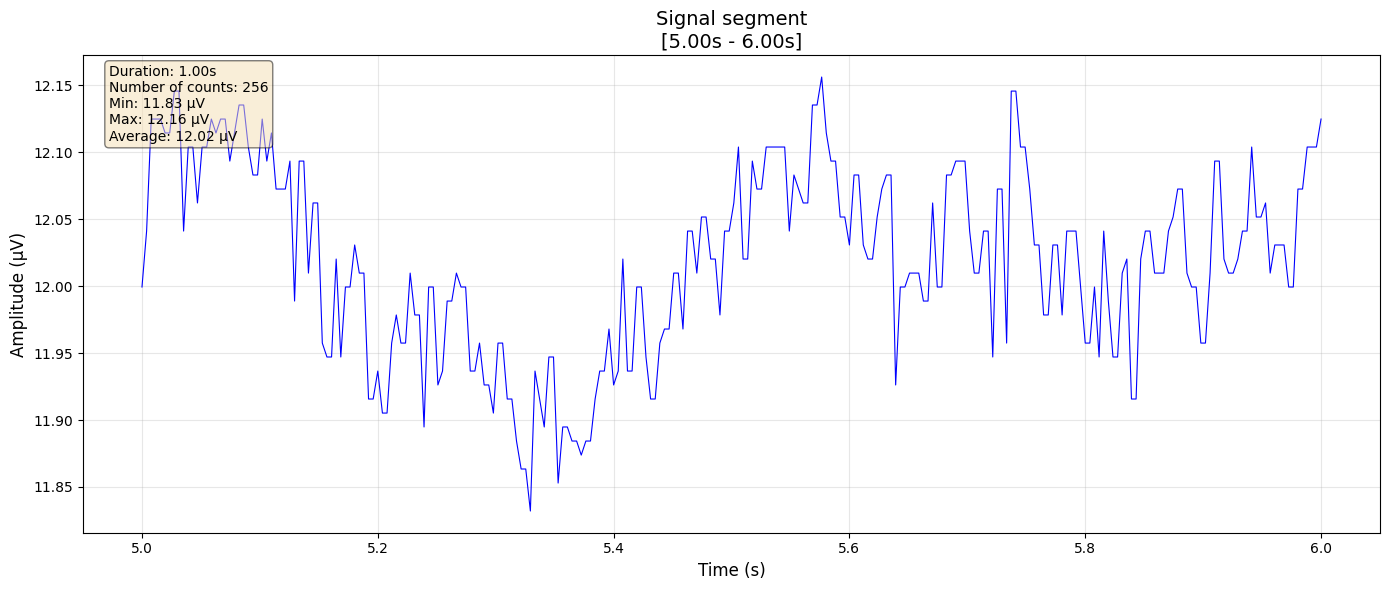

Segment: 256 counts from 5.00s to 6.00s


(array([5.        , 5.00392157, 5.00784314, 5.01176471, 5.01568627,
        5.01960784, 5.02352941, 5.02745098, 5.03137255, 5.03529412,
        5.03921569, 5.04313725, 5.04705882, 5.05098039, 5.05490196,
        5.05882353, 5.0627451 , 5.06666667, 5.07058824, 5.0745098 ,
        5.07843137, 5.08235294, 5.08627451, 5.09019608, 5.09411765,
        5.09803922, 5.10196078, 5.10588235, 5.10980392, 5.11372549,
        5.11764706, 5.12156863, 5.1254902 , 5.12941176, 5.13333333,
        5.1372549 , 5.14117647, 5.14509804, 5.14901961, 5.15294118,
        5.15686275, 5.16078431, 5.16470588, 5.16862745, 5.17254902,
        5.17647059, 5.18039216, 5.18431373, 5.18823529, 5.19215686,
        5.19607843, 5.2       , 5.20392157, 5.20784314, 5.21176471,
        5.21568627, 5.21960784, 5.22352941, 5.22745098, 5.23137255,
        5.23529412, 5.23921569, 5.24313725, 5.24705882, 5.25098039,
        5.25490196, 5.25882353, 5.2627451 , 5.26666667, 5.27058824,
        5.2745098 , 5.27843137, 5.28235294, 5.28

In [45]:
plot_signal_segment(df['bottom_left_f_kg'].values, 256, 5, 6)

1) Обрати будь-які два типи сигналів (наприклад, base-open та sway_left-right_60) для двох типів спортсменів. 

2) Для кожного сигналу в папці відповідного типу порахувати статистичні параметри (середнє значення, медіанне значення, середнє квадратичне відхилення), окремо по осям Х та Y, звести в таблицю.


In [46]:
def stats_val_calculation(folder):
    contents = os.listdir(folder)
    all_dfs = []
    
    for file in contents:
        file_path = os.path.join(folder, file)        
        df = read_stabilogram_data(file_path)
        all_dfs.append(df)
    combined_df = pd.concat(all_dfs, ignore_index=True)

    average_vals = {k: round(v, 2) for k, v in combined_df.mean().items()}
    medians = {k: round(v, 2) for k, v in combined_df.median().items()}
    stds = {k: round(v, 2) for k, v in combined_df.std().items()}

    # print (medians)
    # print(average_vals)
    # print (stds)

    return {'medians': medians, 'average_vals': average_vals, 'stds': stds}

sportsmen = ["acrobats", "handball"]
kinds_of_signals = ['base_open', 'sway_left-right_60']

sets_of_values = [['data/'+i+ '/' + j for j in kinds_of_signals] for i in sportsmen]
flat = [item for sublist in sets_of_values for item in sublist]
result = stats_val_calculation('data/acrobats/base_open')
result = {i:stats_val_calculation(i) for i in flat}

To create nice looking tables:

In [47]:
def create_html_comparison(data, parameters=['cop_x', 'cop_y', 'total_f', 'top_left_f_kg', 'top_right_f_kg', 'bottom_right_f_kg', 'bottom_left_f_kg']):
    """
    Creates HTML table for Jupyter
    """
    from IPython.display import HTML, display
    
    for param in parameters:
        html = f"<h3>Parameter: {param}</h3>"
        html += "<table border='1' style='border-collapse: collapse;'>"
        html += "<tr><th>Experiment</th><th>Mean<br>(Acr/Hand)</th><th>Median<br>(Acr/Hand)</th><th>STD<br>(Acr/Hand)</th></tr>"
        
        experiments = sorted(set([key.split('/')[-1] for key in data.keys()]))
        
        for exp in experiments:
            acr_key = f'data/acrobats/{exp}'
            hand_key = f'data/handball/{exp}'
            
            if acr_key in data and param in data[acr_key]['average_vals']:
                acr_mean = data[acr_key]['average_vals'][param]
                acr_median = data[acr_key]['medians'][param]
                acr_std = data[acr_key]['stds'][param]
                
                hand_mean = data[hand_key]['average_vals'][param]
                hand_median = data[hand_key]['medians'][param]
                hand_std = data[hand_key]['stds'][param]
                
                mean_cell = f"<span style='color:{'yellow' if acr_mean < hand_mean else 'red'}'>{acr_mean:.2f}</span> / "
                mean_cell += f"<span style='color:{'yellow' if hand_mean < acr_mean else 'red'}'>{hand_mean:.2f}</span>"
                
                median_cell = f"<span style='color:{'yellow' if acr_median < hand_median else 'red'}'>{acr_median:.2f}</span> / "
                median_cell += f"<span style='color:{'yellow' if hand_median < acr_median else 'red'}'>{hand_median:.2f}</span>"
                
                std_cell = f"<span style='color:{'yellow' if acr_std < hand_std else 'red'}'>{acr_std:.2f}</span> / "
                std_cell += f"<span style='color:{'yellow' if hand_std < acr_std else 'red'}'>{hand_std:.2f}</span>"
                
                html += f"<tr><td>{exp}</td>"
                html += f"<td>{mean_cell}</td>"
                html += f"<td>{median_cell}</td>"
                html += f"<td>{std_cell}</td></tr>"
        
        html += "</table>"
        display(HTML(html))

create_html_comparison(result)

Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,-0.15 / 0.19,-0.09 / 0.25,1.46 / 0.88
sway_left-right_60,0.40 / 0.48,1.30 / 0.52,11.15 / 10.22


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,3.68 / 4.33,3.90 / 4.31,1.80 / 1.60
sway_left-right_60,3.37 / 3.37,3.48 / 3.64,3.02 / 2.51


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,39.35 / 69.57,34.19 / 69.97,15.93 / 10.07
sway_left-right_60,37.50 / 68.06,26.46 / 68.03,17.12 / 8.35


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,6.96 / 11.28,6.29 / 10.87,3.39 / 1.95
sway_left-right_60,7.04 / 12.17,4.96 / 10.65,6.25 / 6.58


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,7.99 / 13.27,7.30 / 12.88,3.58 / 2.37
sway_left-right_60,7.95 / 14.50,6.69 / 13.30,5.64 / 7.28


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,11.29 / 21.75,10.45 / 21.00,3.88 / 4.30
sway_left-right_60,11.32 / 20.26,8.73 / 20.05,8.07 / 8.97


Experiment,Mean(Acr/Hand),Median(Acr/Hand),STD(Acr/Hand)
base_open,13.11 / 23.27,12.19 / 22.26,6.03 / 4.51
sway_left-right_60,11.19 / 21.13,10.66 / 21.10,6.43 / 9.42
